In [1]:
import datetime
import math
import os
import numpy as np
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})

#https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/

In [2]:
def plot_measures(values,labels,titulo, x_rotation, fig_size=(8,8)):
        
    ind = np.arange(len(labels))  # the x locations for the groups
    width = 0.45  # the width of the bars

    fig, ax = plt.subplots(figsize=fig_size)
    rects1 = ax.bar(ind, values, width,color='SkyBlue')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Conteos')
    ax.set_title(titulo)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels,rotation = x_rotation)
    
    autolabel(rects1,ax, "center")
    plt.show()
    
def autolabel(rects, ax,xpos='center'):
    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.01*height,
                height, ha=ha[xpos], va='bottom')    

In [3]:
data_dir = os.path.join('data xm','Despacho','AGC Programado')
data_list = list()
real_columns_names = ['Fecha','Recurso','Código Agente'] + [str(i) for i in np.arange(24)]

In [4]:
shape_count = 0
for root, dirs, files in os.walk(data_dir, topdown=False):
    for file in files:
        f = pd.read_excel(os.path.join(root,file))
        f.columns = real_columns_names
        shape_count += f.shape[0]
        data_list.append(f)
        print(os.path.join(root,file),f.shape)

data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2000.xlsx (955, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2001.xlsx (1274, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2002.xlsx (1437, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2003.xlsx (1207, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2004.xlsx (1421, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2005.xlsx (1292, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2006.xlsx (1631, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2007.xlsx (1408, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2008.xlsx (2020, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2009.xlsx (1113, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2010.xlsx (1653, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2011.xlsx (2520, 27)
data xm\Despacho\AGC Programado\AGC_Programado_(kWh)_2012.xlsx (2329, 27)
data xm\Despacho\AGC Programado\AGC_Pro

In [5]:
full_data = pd.concat(data_list)

In [6]:
assert shape_count == full_data.shape[0], 'No coinciden las dimensiones'

In [7]:
full_data.dropna(inplace=True,how='all')

In [8]:
full_data.shape

(31183, 27)

In [9]:
full_data.columns

Index(['Fecha', 'Recurso', 'Código Agente', '0', '1', '2', '3', '4', '5', '6',
       '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '20', '21', '22', '23'],
      dtype='object')

# Recursos

In [10]:
datos_copy = full_data.copy()

In [11]:
recursos_unicos = pd.unique(datos_copy['Recurso'])

In [12]:
'Cantidad de Recursos Unicos: {}'.format(len(recursos_unicos))

'Cantidad de Recursos Unicos: 19'

In [13]:
recursos_unicos_conteo = datos_copy.groupby('Recurso')['Fecha'].count()
recursos_unicos_conteo = recursos_unicos_conteo.sort_values(ascending=False)

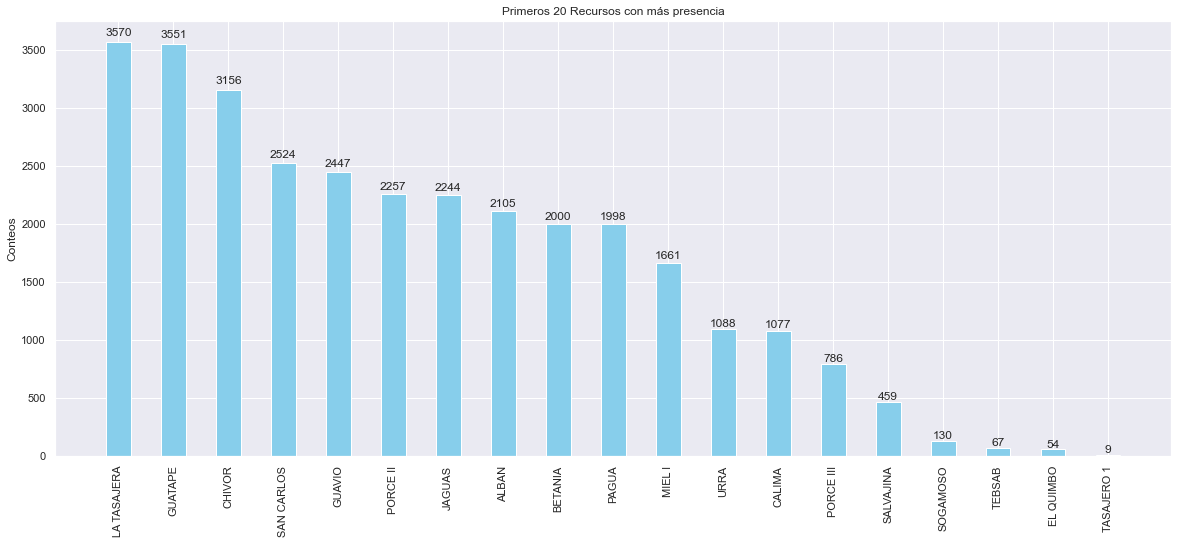

In [14]:
recursos_unicos_primeros = recursos_unicos_conteo[:20]
values = recursos_unicos_primeros.values
labels = recursos_unicos_primeros.index
plot_measures(values,labels,'Primeros 20 Recursos con más presencia',x_rotation=90,fig_size=(20,8))

# GENERAR DATASET CON SERIE

In [15]:
def construir_dataset(df_transpuesto):
    lambda_horas = lambda x: pd.Timedelta(datetime.datetime.strptime(x,'%H').hour, unit='hours')
    
    df_transpuesto['Fecha'] =  pd.to_datetime(df_transpuesto['Fecha'], format='%Y-%m-%d')
    df_transpuesto['variable'] = df_transpuesto['variable'].map(lambda_horas)
    
    df_transpuesto['Fecha'] = df_transpuesto['Fecha'] +  df_transpuesto['variable']
    df_transpuesto = df_transpuesto.sort_values(['Recurso','Fecha'])
    df_transpuesto.drop('variable', axis=1, inplace = True)
    df_transpuesto.rename(columns={"value": "kWh"}, inplace = True)
    df_transpuesto['kWh'].fillna(value=0, inplace=True)
    
    return df_transpuesto

In [16]:
def dividir_guardar_dataset(dataset,dataset_path,dataset_name):
    maximas_filas_excel = 1048576
    filas_dataset = dataset.shape[0]
    divisiones = 1
    
    if filas_dataset > maximas_filas_excel:
        divisiones = math.ceil(filas_dataset/maximas_filas_excel)
        
    lista_dataset = np.array_split(dataset, divisiones)
    for idx,df in enumerate(lista_dataset):
        df.to_excel(os.path.join(dataset_path,'{}_{}.xlsx'.format(dataset_name,idx)))
        print('---> Tamaño División: {}'.format(df.shape))

In [17]:
datos_copy = full_data.copy()

In [18]:
df_transpuesto = pd.melt(datos_copy,
                     id_vars=['Fecha', 'Recurso', 'Código Agente',],
                     value_vars=['0', '1', '2', '3','4', '5', '6', '7', '8', '9', '10', '11', '12',
                                 '13', '14', '15', '16','17', '18', '19', '20', '21', '22', '23'])

dataset = construir_dataset(df_transpuesto)
dataset_path = os.path.join('data series','Despacho')

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

dividir_guardar_dataset(dataset,dataset_path,dataset_name='Despacho')

---> Tamaño División: (748392, 4)


# Visualización de los datos

In [19]:
def obtener_datos_por_recurso(data,nombre_recurso):
    
    datos_recurso = data[data['Recurso'] == nombre_recurso]
    datos_recurso = datos_recurso.copy()

    datos_recurso = datos_recurso.set_index('Fecha')
    
    datos_recurso['Año'] = datos_recurso.index.year
    datos_recurso['Mes'] = datos_recurso.index.month
    datos_recurso['Dia'] = datos_recurso.index.day_name()
    
    return datos_recurso

In [20]:
def grafico_comportamiento(datos):
    cols_plot = ['kWh']
    nombre_graficas = ['kWh']
    axes = datos[cols_plot].plot(alpha=0.8, linestyle='-', figsize=(15, 5), subplots=True)
    for ax,name in zip(axes,nombre_graficas):
        ax.set_ylabel(name)

In [21]:
def grafico_comportamiento_por_mes(datos):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    
    sns.boxplot(data=datos, x='Mes', y='kWh', ax=ax)
    ax.set_title('kWh')

In [22]:
def grafico_filtrado_fecha(datos,fecha_min,fecha_max):
    ax = datos.loc[fecha_min:fecha_max, 'kWh'].plot(marker='o',linestyle='-',figsize=(15, 5))
    ax.set_ylabel('kWh');

In [23]:
def grafico_resampling_rolling_window(datos,fecha_min,fecha_max):
    cols_plot = ['kWh']
    datos_7d = datos[cols_plot].rolling(7, center=True).mean()

    fig, ax = plt.subplots(figsize=(15, 5))

    ax.plot(datos.loc[fecha_min:fecha_max, 'kWh'],
    marker='.', linestyle='-', linewidth=0.5, label='Diaria')

    ax.plot(datos_7d.loc[fecha_min:fecha_max, 'kWh'],linestyle='-', label='Media Movil 7-Días')

    ax.set_ylabel('kWh')
    ax.legend();

In [24]:
pd.unique(dataset['Recurso'])

array(['ALBAN', 'BETANIA', 'CALIMA', 'CHIVOR', 'EL QUIMBO', 'GUATAPE',
       'GUAVIO', 'JAGUAS', 'LA TASAJERA', 'MIEL I', 'PAGUA', 'PORCE II',
       'PORCE III', 'SALVAJINA', 'SAN CARLOS', 'SOGAMOSO', 'TASAJERO 1',
       'TEBSAB', 'URRA'], dtype=object)

In [25]:
recurso = obtener_datos_por_recurso(dataset,nombre_recurso='PORCE II')

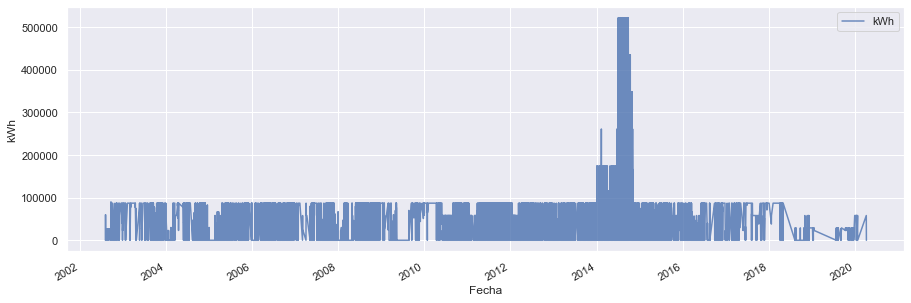

In [26]:
grafico_comportamiento(recurso)

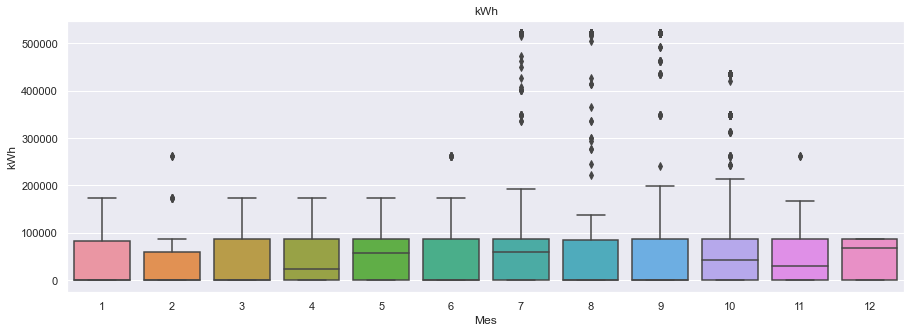

In [27]:
grafico_comportamiento_por_mes(recurso)

In [28]:
'Fecha Mínima {} - Fecha Máxima {}'.format(recurso.index.min(),recurso.index.max())

'Fecha Mínima 2002-08-09 00:00:00 - Fecha Máxima 2020-04-06 23:00:00'

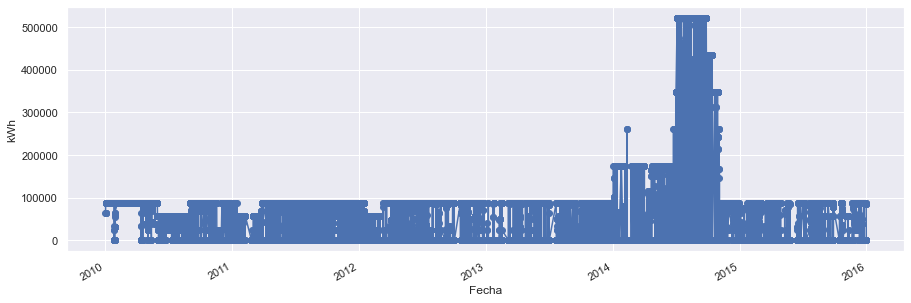

In [29]:
grafico_filtrado_fecha(datos=recurso,fecha_min='2010-01',fecha_max='2015-12')

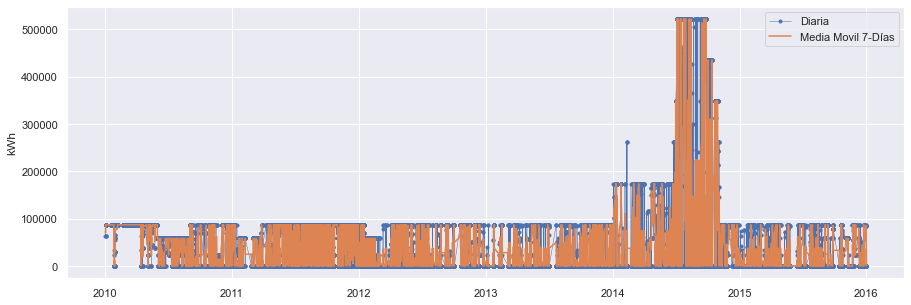

In [30]:
grafico_resampling_rolling_window(datos=recurso,fecha_min='2010-01',fecha_max='2015-12')